# Advanced Lane Detection

This goal of this project is to detect lanes and car position, using images taken from car cameras. To achieve this goal, I will first need to find the car cameras distortion coefficients and calibration matrix to undistort the camera image, then apply appropriate transforms (gradient, color, Sobol, Laplacian, etc...) to create a binary image and detect the lanes. In order to be able to detect curvatures in the road, perspective transforms will be applied.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import glob
import random

## Camera Calibration
The first step is to calibrate the camera. In order to achieve this, images from the camera_cal are used. In these images, there are 9 inside corners in each row and 6 inside corners in each column of the checkerboard.

### Load and import calibration data

camera_cal/calibration10.jpg


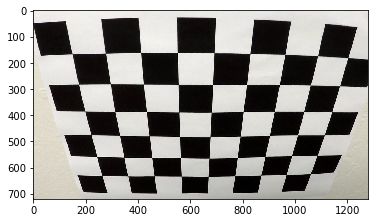

In [3]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images using glob to import similarly named files
imagefiles = glob.glob("camera_cal/calibration*.jpg")

print(imagefiles[random.randrange(0,10)])

image = mpimg.imread(imagefiles[random.randrange(0,10)])
plt.imshow(image)


In [4]:
# Initialise image and object point arrays
objpoints = [] # 3D points in real space
imgpoints = [] # 2D points in image plane

# Prepare object points (0,0,0), (0,1,0), (9,6,0) - all z's should be zero
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

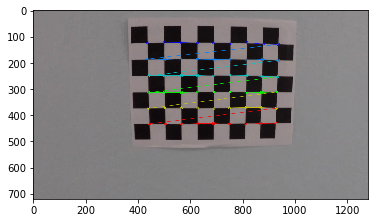

In [5]:
for filename in imagefiles:
    image = cv2.imread(filename)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        # Add object points
        objpoints.append(objp)
        # Add image points
        imgpoints.append(corners)
        
# Draw and display the corners
cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
plt.imshow(image)

### Compare calibrated and uncalibrated images


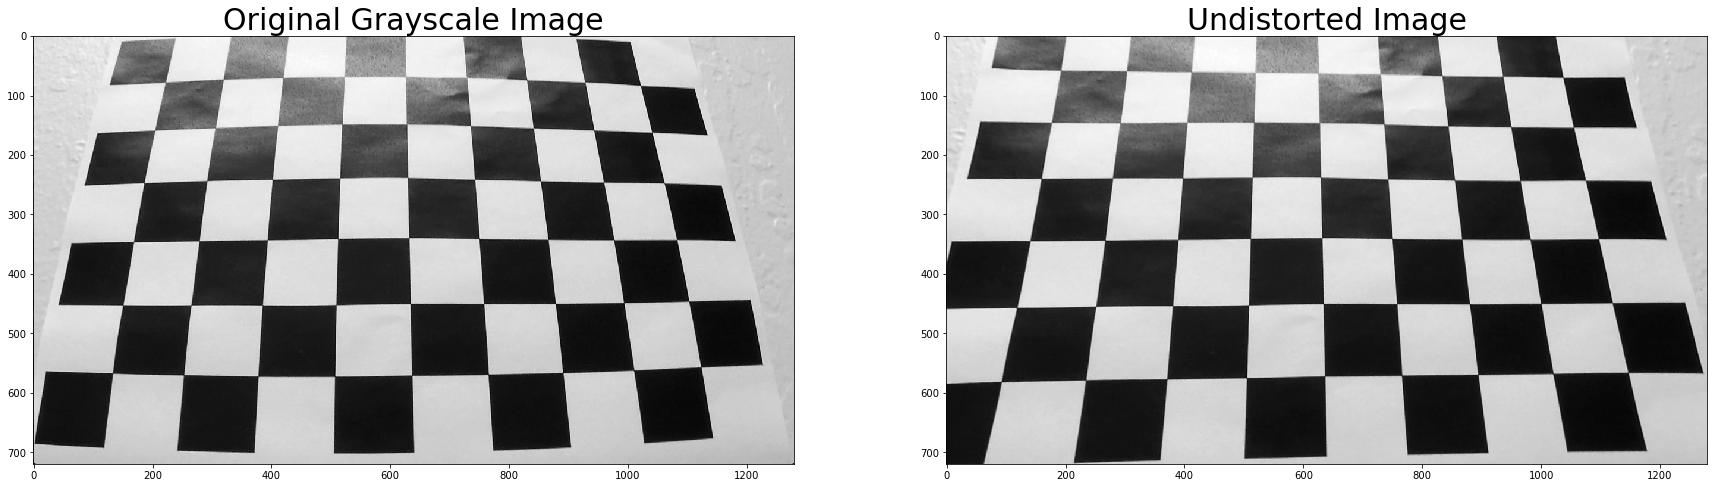

In [6]:
image = cv2.imread(imagefiles[13])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist = cv2.undistort(gray, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(gray, cmap='gray')
ax1.set_title('Original Grayscale Image', fontsize=30)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

### Example of undistorting image
Here an example of distorted and undistorted image taken from the car camera.

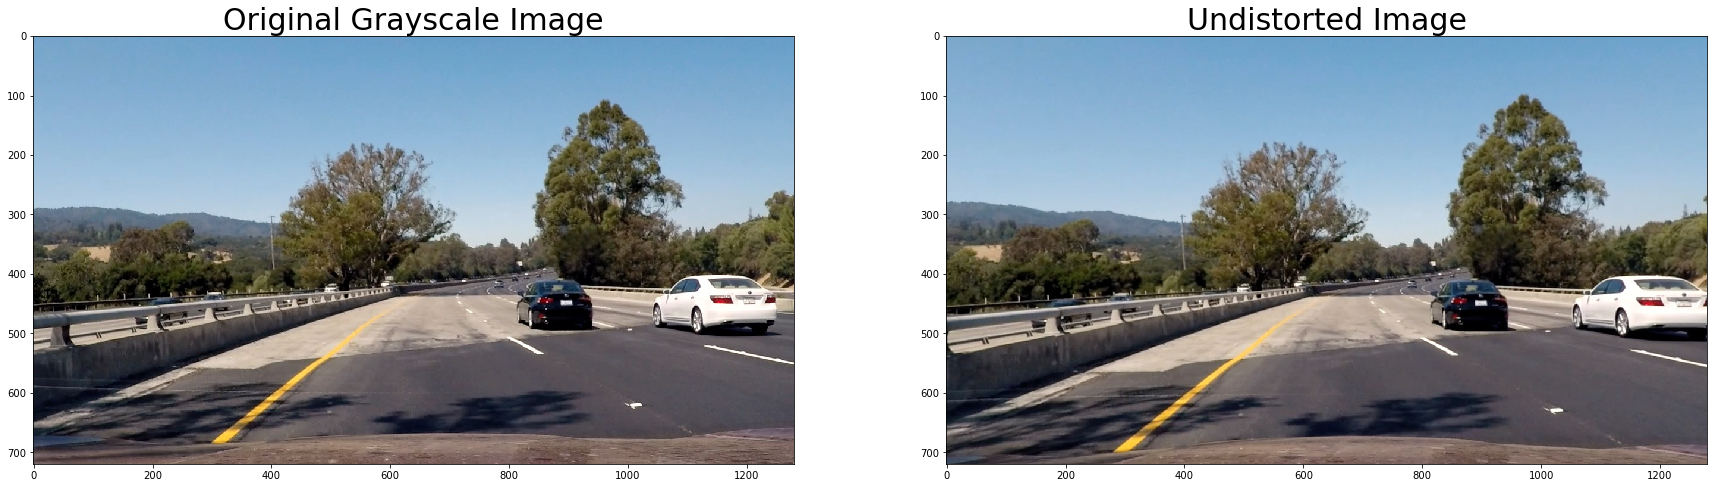

In [7]:
image = mpimg.imread('test_images/test4.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(image)
ax1.set_title('Original Grayscale Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Using color transforms and gradients to create a threshold binary image
The next section will try to create an appropriate binary image using color transforms and gradients.

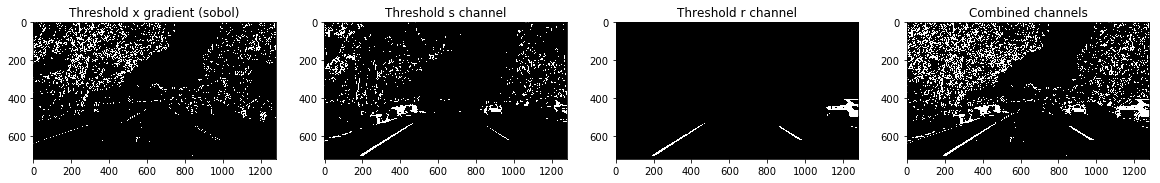

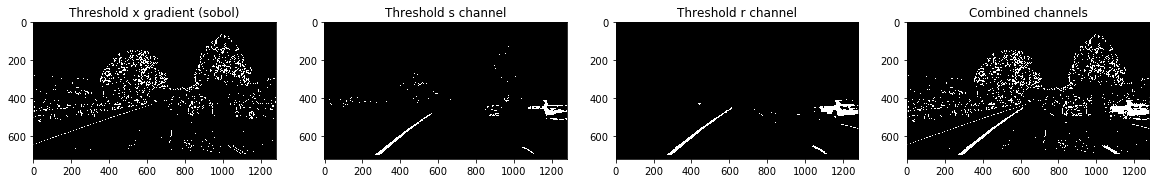

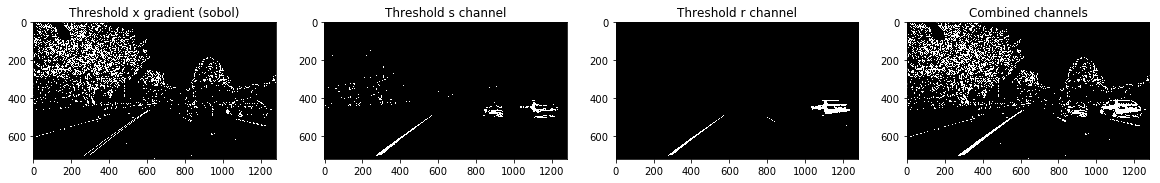

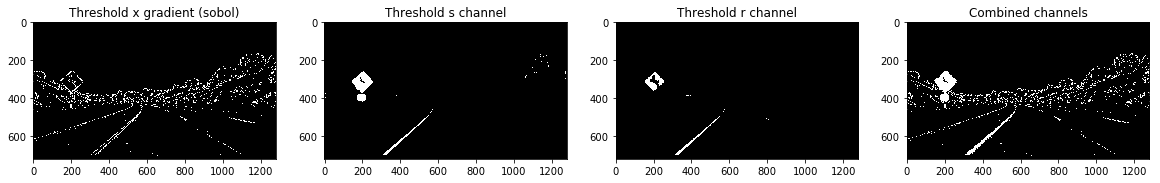

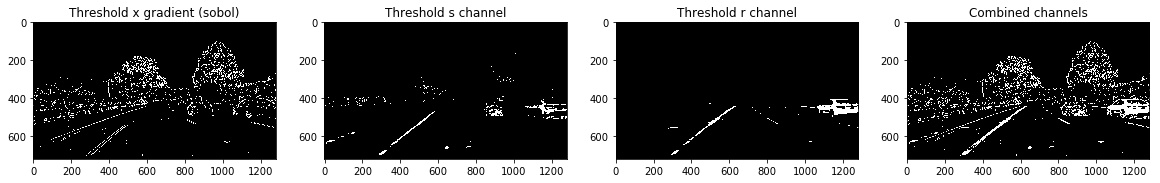

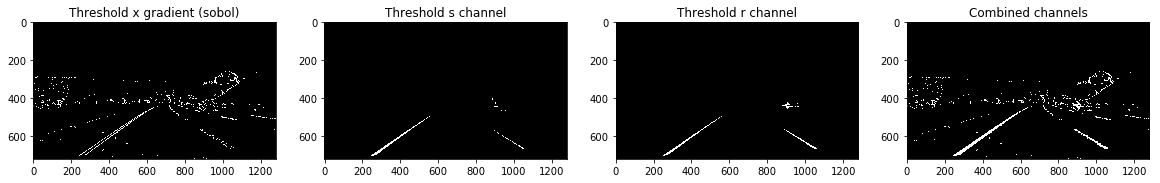

In [32]:
def get_binary_image(img, display=True):
    blur = cv2.GaussianBlur(img, (3, 7), 0)
    r_channel = blur[:,:,2]
    r_thresh = (220, 255)
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 160
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1)] = 1
    
    if display:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
        ax1.set_title('Threshold x gradient (sobol)')
        ax1.imshow(sxbinary, cmap='gray')

        ax2.set_title('Threshold s channel')
        ax2.imshow(s_binary, cmap='gray')

        ax3.set_title('Threshold r channel')
        ax3.imshow(r_binary, cmap='gray')

        ax4.set_title('Combined channels')
        ax4.imshow(combined_binary, cmap='gray')
        
    return(combined_binary)


# Make a list of calibration images using glob to import similarly named files
imagefiles = glob.glob("test_images/test*.jpg")

for filename in imagefiles:
    image = cv2.imread(filename) 
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    combined_binary = get_binary_image(undist)


It can be seen from the test images that the combination of color and sobol gradient in the x axis is able to identify the lanes pretty consisitantly in these images.

## Perspective transform
The next step is to find the correct perspective transform to warp the image such that we have a birds eye view instead of the camera view we have now.

In [82]:
def get_perspective_transform():
    src = np.float32(
        [[572, 455],
         [0, 720],
         [1280, 720],
         [700, 455]])

    dst = np.float32(
        [[160, 0],
         [160, 720],
         [1120, 720],
         [1120, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

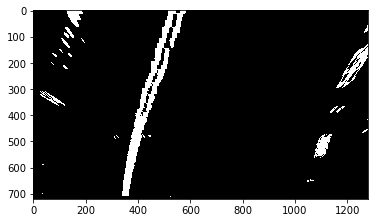

In [97]:
def apply_perspective_transform(img, M):
    imshape = img.shape
    # Warp onto birds-eye-view
    # Previous region-of-interest mask's function is absorbed by the warp
    warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return warped
    
#for filename in imagefiles:
#    image = cv2.imread(filename) 
image = cv2.imread('test_images/test6.jpg')

M, Minv = get_perspective_transform()

undist = cv2.undistort(image, mtx, dist, None, mtx)
combined_binary = get_binary_image(image, display=False)
combined_binary_warped = apply_perspective_transform(undist, M)
plt.imshow(combined_binary_warped, cmap='gray')

## Find lane lines
### Using Histogram
First I will use a histogram of the image to find the lanes. 

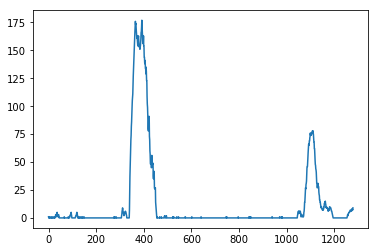

In [98]:
histogram = np.sum(combined_binary_warped[combined_binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

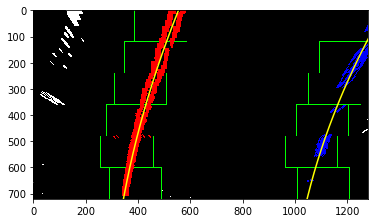

In [99]:
def sliding_window_histogram(binary_warped):
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 6
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit, right_fit, ploty, leftx, rightx

left_fit, right_fit, ploty, leftx, rightx = sliding_window_histogram(combined_binary_warped)



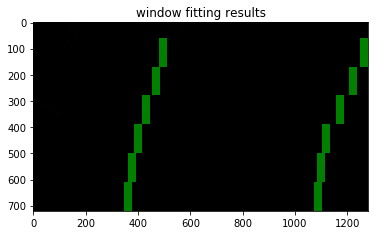

In [100]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

def sliding_window_histogram(img, window_width=30, window_height=110, margin=150):
    window_centroids = find_window_centroids(img, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((img,img,img)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If we found any window centers
    else:
        output = np.array(cv2.merge((combined_binary_warped,combined_binary_warped,combined_binary_warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
    return output

imgoutput = sliding_window_histogram(combined_binary_warped)


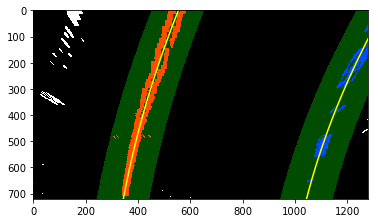

In [101]:
def search_known_window(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return result, left_fit, right_fit, ploty, leftx, rightx, lefty, righty, left_fitx, right_fitx

result, left_fit, right_fit, ploty, leftx, rightx, lefty, righty, left_fitx, right_fitx = search_known_window(combined_binary_warped, left_fit, right_fit)

### Measure curvature


In [102]:
def get_curvature(left_fit, right_fit, ploty, leftx, rightx, lefty, righty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

left_curverad, right_curverad = get_curvature(left_fit, right_fit, ploty, leftx, rightx, lefty, righty)


3566.30427419 2644.9756222
1113.94275976 m 790.231099297 m


### Draw back onto the original image


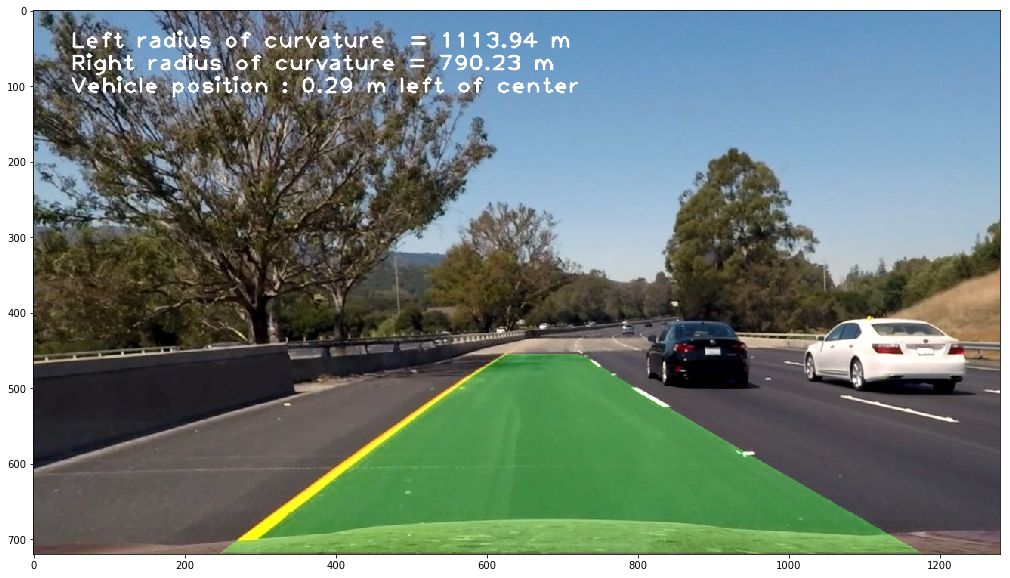

In [103]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

xm_per_pix = 3.7/700 # meters per pixel in x dimension
middle = (left_fitx[-1] + right_fitx[-1])//2
veh_pos = image.shape[1]//2
dx = (veh_pos - middle)*xm_per_pix # Positive if on right, Negative on left
cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(50,50), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
#is_tracking = left_lane.detected or right_lane.detected
#cv2.putText(result,'Tracking Locked' if is_tracking else 'Tracking Lost',(50,140), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0) if is_tracking else (255,0,0), 3,cv2.LINE_AA)


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2BGR))





# Pipeline for video